# Compute accuracy for NCC-UCRL2 and Sim-OOS

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [14]:
new_contexts.shape, new_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


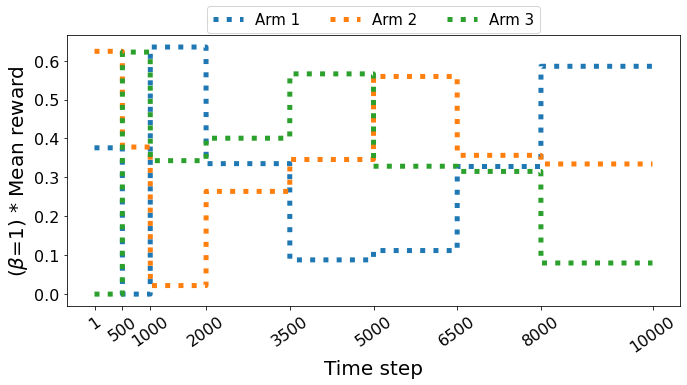

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [16]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [17]:
cost_means_range = [0.01, 0.07]

In [18]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [19]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [20]:
interval_means

[array([0.03247241, 0.06704286, 0.05391964, 0.04591951, 0.01936112]),
 array([0.01935967, 0.01348502, 0.06197057, 0.0460669 , 0.05248435]),
 array([0.01123507, 0.06819459, 0.05994656, 0.02274035, 0.0209095 ]),
 array([0.02100427, 0.02825453, 0.04148539, 0.0359167 , 0.02747375]),
 array([0.04671117, 0.01836963, 0.02752868, 0.03198171, 0.0373642 ])]

In [21]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [22]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

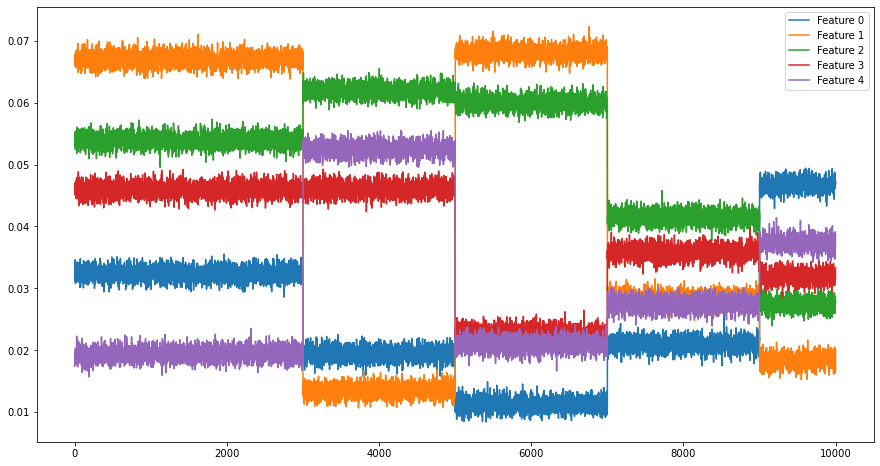

In [23]:
plot_costs(get_costs(), new_contexts.shape[0])

In [24]:
costs_obj = get_costs()

In [25]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [26]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [27]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [28]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

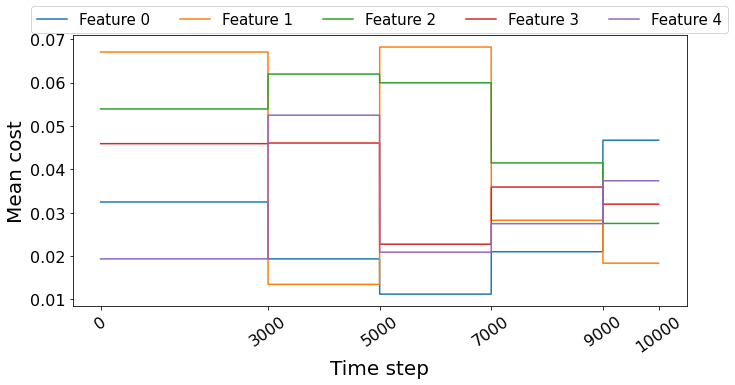

In [29]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [30]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.22633150496472904
Min expected gain for arm 2: -0.2036502630607873
Min expected gain for arm 3: -0.22429558772004018


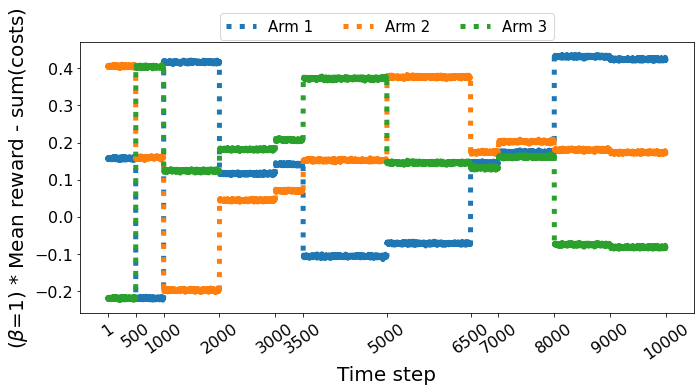

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


## Testing on non-stationary data

In [32]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5
N_FEATURES = all_contexts.shape[1]

In [33]:
np.random.seed(42)

In [34]:
def get_accuracy_new(policy_object):
    N_FEATURES = policy_object.max_no_red_context
    counts = np.zeros(N_FEATURES+1, dtype=int)
    rewards = np.zeros(N_FEATURES+1, dtype=int)
    accuracies = np.zeros(N_FEATURES+1)
    
    T = len(policy_object.selected_context_SimOOS)
    
    # for each l what happens when we observe up to l features
    for l in range(len(counts)):
        for j in range(l+1):
            for t in range(T):
                observation = policy_object.selected_context_SimOOS[t, :]
                reward = policy_object.collected_rewards_SimOOS[t]
                num_observed = np.count_nonzero(observation)
                
                indicator = 1 if (num_observed == j) else 0
                counts[l] += indicator
                rewards[l] += reward * indicator
                
    print(rewards)
    print(counts)
    for l in range(len(accuracies)):
        accuracies[l] = rewards[l] / counts[l] if counts[l] != 0 else 0
    return accuracies

In [35]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
accuracies_simoos = np.zeros((NUM_REPETITIONS, N_FEATURES+1))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.8,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos, reward_simoos, cost_simoos, _ = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos
    rewards_simoos[i, :] = reward_simoos
    costs_simoos[i, :] = cost_simoos
    accuracies_simoos[i, :] = get_accuracy_new(p_simoos)

gain_simoos = np.mean(gains_simoos, axis=0)
reward_simoos = np.mean(rewards_simoos, axis=0)
cost_simoos = np.mean(costs_simoos, axis=0)
accuracy_simoos = np.mean(accuracies_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0013990402221679688 seconds
Trial 0, time 2022-06-08 10:36:39.219169
Trial 500, time 2022-06-08 10:36:51.371122
Trial 1000, time 2022-06-08 10:37:03.103465
Trial 1500, time 2022-06-08 10:37:05.182249
Trial 2000, time 2022-06-08 10:37:32.840353
Trial 2500, time 2022-06-08 10:38:03.274099
Trial 3000, time 2022-06-08 10:38:09.668627
Trial 3500, time 2022-06-08 10:38:17.533879
Trial 4000, time 2022-06-08 10:38:18.606574
Trial 4500, time 2022-06-08 10:38:19.554714
Trial 5000, time 2022-06-08 10:38:20.728600
Trial 5500, time 2022-06-08 10:38:30.239408
Trial 6000, time 2022-06-08 10:38:38.549583
Trial 6500, time 2022-06-08 10:38:38.944713
Trial 7000, time 2022-06-08 10:38:40.199720
Trial 7500, time 2022-06-08 10:38:41.349742
Trial 8000, time 2022-06-08 10:38:42.512464
Trial 8500, time 2022-06-08 10:38:42.762081
Trial 9000, time 2022-06-08 10:38:44.445141
Trial 9500, time 2022-06-08 10:38:45.902201
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 2903.5517130239627
	Total reward: 4081.0


In [ ]:
gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
accuracies_alg1 = np.zeros((NUM_REPETITIONS, N_FEATURES+1))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1, reward_alg1, cost_alg1, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1[i, :] = gain_alg1
        rewards_alg1[i, :] = reward_alg1
        costs_alg1[i, :] = cost_alg1
        accuracies_alg1[i, :] = get_accuracy_new(p_alg1)

gain_alg1 = np.mean(gains_alg1, axis=0)
reward_alg1 = np.mean(rewards_alg1, axis=0)
cost_alg1 = np.mean(costs_alg1, axis=0)
accuracy_alg1 = np.mean(accuracies_alg1, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0015358924865722656 seconds
Round 0, time 2022-06-08 10:47:24.192029
Round 500, time 2022-06-08 10:48:27.932947
Round 1000, time 2022-06-08 10:49:36.597675
Round 1500, time 2022-06-08 10:50:44.832307
Round 2000, time 2022-06-08 10:51:53.148504
Round 2500, time 2022-06-08 10:53:01.662048
Round 3000, time 2022-06-08 10:54:09.803795
Round 3500, time 2022-06-08 10:55:18.239826
Round 4000, time 2022-06-08 10:56:26.558676
Round 4500, time 2022-06-08 10:57:34.898525
Round 5000, time 2022-06-08 10:58:43.106760
Round 5500, time 2022-06-08 10:59:51.540527
Round 6000, time 2022-06-08 11:01:00.580414
Round 6500, time 2022-06-08 11:02:10.879327
Round 7000, time 2022-06-08 11:03:20.357892
Round 7500, time 2022-06-08 11:04:30.596847
Round 8000, time 2022-06-08 11:05:42.124848
Round 8500, time 2022-06-08 11:06:51.193802
Round 9000, time 2022-06-08 11:07:59.921774
Round 9500, time 2022-06-08 11:09:09.425165
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 6800.445460400327
	Total rewa

### Oracle

In [ ]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [ ]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
accuracies_alg1_oracle = np.zeros((NUM_REPETITIONS, N_FEATURES+1))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle, reward_alg1_oracle, cost_alg1_oracle, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle
        rewards_alg1_oracle[i, :] = reward_alg1_oracle
        costs_alg1_oracle[i, :] = cost_alg1_oracle
        accuracies_alg1_oracle[i, :] = get_accuracy_new(p_alg1_oracle)



gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
reward_alg1_oracle = np.mean(rewards_alg1_oracle, axis=0)
cost_alg1_oracle = np.mean(costs_alg1_oracle, axis=0)
accuracy_alg1_oracle = np.mean(accuracies_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

In [ ]:
data_to_save = {
    'mean_accuracies': {
        'SimOOS': accuracy_simoos,
        'Algorithm1': accuracy_alg1,
        'Oracle': accuracy_alg1_oracle,
    },
    'accuracies': {
        'SimOOS': accuracies_simoos,
        'Algorithm1': accuracies_alg1,
        'Oracle': accuracies_alg1_oracle,
    },
    'reward_change_points': change_point_values,
    'cost_change_points': cost_change_points,
    'all_change_points': all_change_point_values,
}

In [ ]:
with open('experiments/nursery/results/accuracies_averaging.pickle', 'wb') as f:
    pickle.dump(data_to_save, f)

## Load data back

In [ ]:
# with open('experiments/nursery/results/accuracies_averaging.pickle', 'rb') as f:
#     data_to_save = pickle.load(f)

In [ ]:
accuracies = data_to_save['mean_accuracies']

In [ ]:
accuracies 

In [ ]:
accuracies_to_plot = {
    'NCC-UCRL2': accuracies['Algorithm1'],
    'Sim-OOS': accuracies['SimOOS']
}

In [ ]:


fig, ax = plt.subplots(1, figsize=(10, 5))
ind_to_params = {
        # ind: (mark, color)
        0: ('d','red'), 1:('s', 'darkblue') , 2:('o','deepskyblue') , 3: ('>','orange'),
        4: ('^', 'm'), 5: ('<', 'k'), 6: ('x','green'),
    }

for ind, (algorithm_name, accuracy_for_cost) in enumerate(accuracies_to_plot.items()):

    mark, color = ind_to_params[ind]
    ax.plot(
        range(len(accuracy_for_cost)),
        accuracy_for_cost,
        label=algorithm_name,
        marker=mark, markersize=8, fillstyle='none',
        c=color, linestyle=':', linewidth=3,
    )
    
ax.set_xlabel('Number Of Observations', fontsize=26)
ax.set_ylabel('Accuracy', fontsize=26)
ax.set_ylim(0.0, 0.8)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Only integer labels

plt.legend(prop={'size': 24}, loc='lower right');
plt.savefig('experiments/nursery/making_figures/nursery_accuracy_alt_final.pdf', bbox_inches='tight')

plt.show()

In [ ]:
def plot_gains(gain_dict, reward_change_points=(), cost_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', 
                marker=mark, markevery=750, markersize=10,
                fillstyle='none', color=color,
                linewidth=3,
               )
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4, label='Change points'
    )
    
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=20)
    plt.yticks(fontsize=20)
    
    ax.set_xlabel('Time step', fontsize=26)
    ax.set_ylabel('Cumulative gain', fontsize=26)
    
    plt.legend(prop={'size': 20});
    plt.show();

In [ ]:
plot_gains(
    {
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
    },
    reward_change_points=change_point_values,
    cost_change_points=cost_change_points,
)
